# Projet Elections

On va d'abord essayer de construire un modèle pour prédire le vote global.  
Ensuite on pourra essayer de prédire le résultat du collège électoral, qui détermine le vainqueur de l'élection générale.

In [2]:
library(tidyverse)
library(dslabs)
library(gridExtra)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'dslabs' was built under R version 3.6.2"Warning message:
"package 'gridExtra' was built under R version 3.6.2"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



### Données

In [3]:
data(polls_us_election_2012)

Warning message in data(polls_us_election_2012):
"data set 'polls_us_election_2012' not found"

In [55]:
head(polls_us_election_2016, n=3)

state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin
U.S.,2016-11-03,2016-11-06,ABC News/Washington Post,A+,2220,lv,47.00,43.00,4.00,NA,45.20163,41.72430,4.626221,NA
U.S.,2016-11-01,2016-11-07,Google Consumer Surveys,B,26574,lv,38.03,35.69,5.46,NA,43.34557,41.21439,5.175792,NA
U.S.,2016-11-02,2016-11-06,Ipsos,A-,2195,lv,42.00,39.00,6.00,NA,42.02638,38.81620,6.844734,NA


On ne garde que les sondages sur le pays en entier :

In [56]:
polls = filter(polls_us_election_2016, state == "U.S.")

On remarque que certains sondages sont jugés par les auteurs du dataset comme moins précis ou fiable que les autres, ayant une note plus faible. On les retire.

In [57]:
polls = filter(polls, grade %in% c("A+","A","A-","B+") | is.na(grade))

De même on ne garde pas les sondages trop vieux, l'élection ayant lieu le 08.11.2016

In [58]:
polls = filter(polls, enddate >= "2016-10-31")

In [59]:
nrow(polls)

[1] 49

On crée une nouvelle variable qu'on appelle spread, l'écart entre clinton et trump.  
Cette variable est comprise entre 1 (Clinton à 100% des votes) et -1 (Trump à 100%)

In [60]:
polls = mutate(polls, spread = rawpoll_clinton/100 - rawpoll_trump/100)
head(polls, n=3)

state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,spread
U.S.,2016-11-03,2016-11-06,ABC News/Washington Post,A+,2220,lv,47,43,4,NA,45.20163,41.72430,4.626221,NA,0.04
U.S.,2016-11-02,2016-11-06,Ipsos,A-,2195,lv,42,39,6,NA,42.02638,38.81620,6.844734,NA,0.03
U.S.,2016-11-03,2016-11-06,Fox News/Anderson Robbins Research/Shaw & Company Research,A,1295,lv,48,44,3,NA,49.02208,43.95631,3.057876,NA,0.04


### Biais des Organismes de sondages :

On voit clairement que certains organismes de sondage sont orientés pour un candidat ou un autre. Il faut prendre en compte ce phénomène pour la suite.  
En effet, certains organismes ont fait plus de sondages que d'autres et donc leur orientation aura plus de poids dans le modèle final, ce que nous devons éviter.

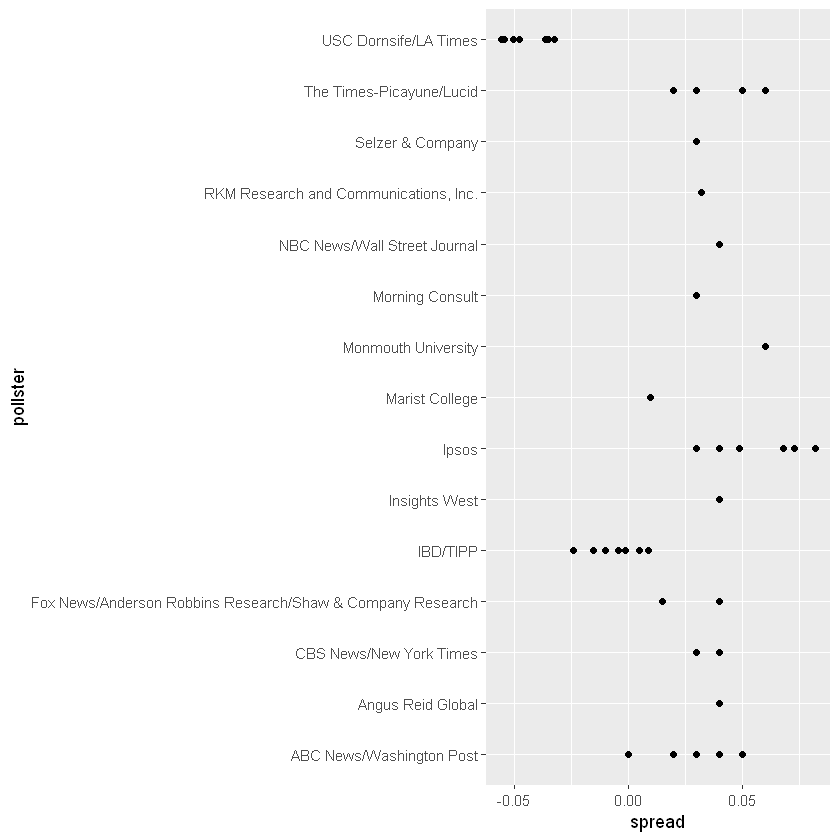

In [61]:
ggplot(polls, aes(x=spread, y=pollster)) +
    geom_point()

# Vote public :

#### Modèle simple :

Pour éviter le biais des organismes et une prépondérance de ceux qui ont fait plus de sondages que les autres, on ne considère pour chacun que le dernier sondage, le plus récent par rapport à la date de l'élection 

In [62]:
unique_poll = group_by(polls, pollster)
unique_poll = filter(unique_poll, enddate == max(enddate)) #On garde le dernier sondage
unique_poll = ungroup(unique_poll)
head(unique_poll, n=3)

state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,spread
U.S.,2016-11-03,2016-11-06,ABC News/Washington Post,A+,2220,lv,47,43,4,NA,45.20163,41.72430,4.626221,NA,0.04
U.S.,2016-11-02,2016-11-06,Ipsos,A-,2195,lv,42,39,6,NA,42.02638,38.81620,6.844734,NA,0.03
U.S.,2016-11-03,2016-11-06,Fox News/Anderson Robbins Research/Shaw & Company Research,A,1295,lv,48,44,3,NA,49.02208,43.95631,3.057876,NA,0.04


Moyenne de l'écart : 
$$\mu_{sondages} = \mu_{données}$$

In [63]:
mu_sondages = mean(unique_poll$spread)
mu_sondages

[1] 0.02898

Si on considère que 15 sondages sont suffisant pour appliquer la loi des grands nombres et le Théorème central limite, on a par approximation en loi normale :

On calcule l'écart-type :
$$\sigma_{sondages} = \frac{ \sigma_{données} }{ \sqrt{N} }$$

In [64]:
sigma_sondages = sd(unique_poll$spread)/sqrt(nrow(unique_poll))
sigma_sondages

[1] 0.006246784

In [65]:
mu_sondages + 1.96*sigma_sondages*c(-1,0,1)

[1] 0.0167363 0.0289800 0.0412237

Le 0 est exclu de l'intervalle de confiance à 95%.  
Le résultat de ce premier modèle simple d'aggrégation des sondages est donc une victoire de Clinton avec $\mu_{sondages}$ à presque 3% d'écart avec Trump, et $\sigma_{sondages}$ suffisamment faible pour affirmer cette victoire avec une grand probabilité.


### Modélisation

Expliquer en 2 spi pq voilà voilà

Le modèle adopté est :  

$$ X_{i,j} = d + B + b_i + \epsilon_{i,j} $$  
  
Avec :  
- $X_{i,j}$ : le résultat du sondage j effectué par l'organisme i
- $d$ : le spread final le jour de l'élection
- $B$ : le biais global, commun à tous les sondages, pour l'élection considérée.  
Modélisé par une loi normale :
$$ B \sim \mathcal{N}\big(\mu_B=0, \sigma_B = 0.025\big) $$
Où  $\mu_B$ et $\sigma_B$ ont étés fixés après étude des élections précédentes et de leurs sondages préalables.
- $b_i$ : le biais de l'organisme i.  
Modélisé par une loi normale :
$$ b_i \sim \mathcal{N}\big(\mu_{b_i}=0, \sigma_{b_i} = 0.025\big) $$

- $\epsilon_{i,j}$ : biais du sondage j de l'organisme i.  
Modélisé également par une loi normale :
$$ \epsilon_{i,j} \sim \mathcal{N}\bigg( \mu_{\epsilon_{i,j}}=0, \sigma_{\epsilon_{i,j}} = \sqrt{\frac{p(1-p)}{N}} \bigg)$$


Avec ce modèle statistique, on a :

$$ \bar{X} = d + B + \frac{1}{N}\displaystyle\sum_{i=1}^{N} X_i $$
Et l'écart-type de $\bar{X}$ est :
$$ \sigma_\bar{X} ² = \sqrt{\frac{\sigma²}{N} + \sigma_B²} $$

On remarque que $\sigma_B²$ n'est pas dépendant du nombre d'observations. Même avec un grand nombre de sondages, on a toujours un certain biais général $B$ propre à l'élection, et ainsi $\sigma_\bar{X} ²$ ne converge pas vers 0.

On vérifie que ce modèle corresponde aux données qu'on a, par une simulation de Monte Carlo :

In [66]:
I = 7 #Nombre d'organismes de sondages
J = 5 #Nombre de sondages par organisme
N = 2000
d = .029
B = rnorm(1, 0, 0.025)
p = (d+1)/2 #pour remettre au format [0, 1]
b = rnorm(I, 0, 0.025)
X = sapply(1:I, function(i){
  d + B + b[i] + rnorm(J, 0, 2 * sqrt(p*(1-p)/N))
})

In [67]:
names = rep(1:I, each=J)
sim_data = data.frame(group=names, spread=c(X))

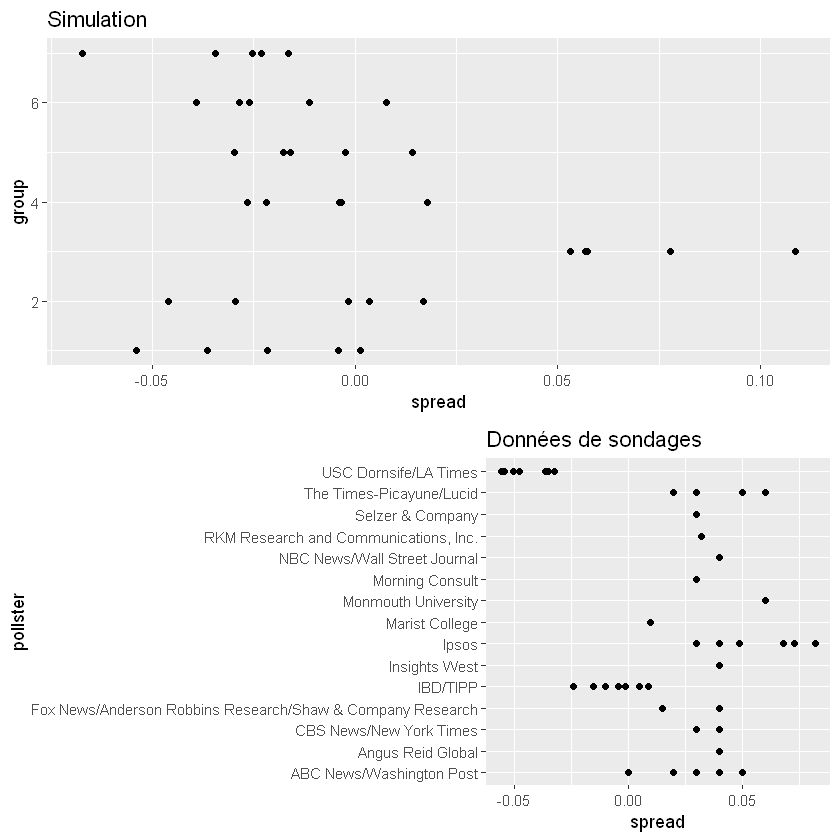

In [68]:

p1 = ggplot(data = sim_data, aes(x=spread, y=group))+ geom_point() + ggtitle("Simulation")
p2 = ggplot(polls, aes(x=spread, y=pollster)) + geom_point() + ggtitle("Données de sondages")
grid.arrange(p1, p2, nrow=2)

Notre simulation semble bien correspondre aux données, donc on valide le modèle adopté.

#### Prédiction en utilisant le paradigme Bayésien

On utilise le modèle du dessus pour notre prédiction de résultat.   
Pour les estimations des paramètres $\mu$ et $\sigma²$ de l'élection, on utlise les résultats du premier modèle :

In [18]:
mu_sondages

[1] 0.02898

In [19]:
sigma_sondages

[1] 0.006246784

On cherche une estimation de d, le spread au jour de l'élection.   
On va utiliser une méthode bayésienne pour prendre en compte les résulats habituels aux élections présidentielles.
- Avec nos connaissances générales sur les résultats courants, on peut construire la loi a priori suivante, concernant l'écart $d$ de résultat démocrate-républicain :
$$ d_{prior} \sim \mathcal{N}(\mu_{prior}, \sigma_{prior}²) $$
    - Comme on ne connait pas le résultat de l'élection clairement, on pose $\mu_{prior} = 0$  
    - Pour l'écart-type, on choisit $\sigma_{prior} = 0.035$ soit 3.5% car c'est l'écart habituel entre deux candidats à la présidentielle américaine.
  
- On réactualise nos données de sondage du début (où l'on a calculé la moyenne $\mu_{sondages}$ et l'écart-type $\sigma_{sondages}$ prévus) dans notre nouveau modèle qui comporte le biais global de tous les sondages.

    On a donc :  
$$\mu_{modèle} = \mu_{sondages} $$
$$\sigma_{modèle} = \sqrt{\sigma_{sondages}² + \sigma_B²}$$
  
- On calcule ensuite la loi a posteriori de l'écart $d$.  
    En effet, comme les lois de l'a priori et des données modélisées suivent une loi normale, la loi a posteriori et la loi a priori sont conjuguées. La loi a posteriori est donc également une loi Normale, avec de nouveaux paramètres que l'on peut retrouver avec les paramètres de la likelihood et de l'a priori.
$$ d_{posterior} \sim \mathcal{N}(\mu_{posterior},\sigma_{posterior}²) $$
    En notant $ C = \frac{\sigma_{prior}²}{\sigma_{modèle}² +\sigma_{prior}²}$ ,  
    On a :
    $$ \mu_{posterior} = C\mu_{prior}   +  (1-C)\mu_{modèle} $$ 
    
    $$ \sigma_{posterior}² = \frac{1}{\frac{1}{\sigma_{modèle}}+\frac{1}{\sigma_{prior}²}}$$



In [20]:
#Paramètres de l'a priori
mu_prior = 0
sigma_prior = 0.035

#Paramètres des données, updatées par notre nouveau modèle (likelihood)
sigma_B = 0.025
sigma_modèle = sqrt(sigma_sondages^2 + sigma_B^2)
Y = mu_sondages #Données des sondages, avec ajout du biais général

#Paramètres posteriori
C = sigma_modèle^2 / (sigma_modèle^2 + sigma_prior^2)
mu_posterior = C*mu_prior + (1-C)*Y
sigma_posterior = sqrt( 1/ (1/sigma_modèle^2 + 1/sigma_prior^2))

In [21]:
mu_posterior + 1.96*sigma_posterior*c(-1, 0, +1)

[1] -0.02187907  0.01879305  0.05946518

Probabilité de Trump de gagner le vote populaire :

In [22]:
pnorm(0, mu_posterior, sigma_posterior)

[1] 0.1825627

Grâce à l'introduction de notre a priori basé sur les observations précédentes, enrichies d'un modèle plus robuste, nous aboutissons à des résultats de prédictions plus proches de la réalité.

# Electoral College

**Bla bla** les élections c'est pas le vote populaire mais les grands électeurs, et donc les états car win them all.

In [23]:
head(arrange(results_us_election_2016, desc(electoral_votes)), n=3)

state,electoral_votes,clinton,trump,others
California,55,61.7,31.6,6.7
Texas,38,43.2,52.2,4.5
Florida,29,47.8,49.0,3.2


In [24]:
head(arrange(results_us_election_2016, electoral_votes), n=3)

state,electoral_votes,clinton,trump,others
Alaska,3,36.6,51.3,12.2
Delaware,3,53.4,41.9,4.7
Montana,3,35.9,56.5,7.6


Tous les états n'ont pas le même nombre de grands électeurs, en fonction de la taille de l'état.  
Nous devons faire la même modélisation, mais état par état, afin de déterminer le nombre de grands électeurs pour chaque candidat, et déterminer le grand vainqueur de l'élection.

On a besoin de recharger (et retraiter) les données, pour ne garder fois-ci que les sondages sur les états :

In [25]:
#On remarque que certains états sont découpés, avec des spécifications "CD".
#On entient compte en les enlevant des données.
unique(polls_us_election_2016$state)

[1] U.S.                 New Mexico           Virginia            
 [4] Iowa                 Wisconsin            North Carolina      
 [7] Georgia              Florida              Oregon              
[10] Ohio                 South Carolina       New York            
[13] Michigan             Pennsylvania         Missouri            
[16] New Hampshire        Arizona              Nevada              
[19] Colorado             California           Washington          
[22] Texas                Utah                 Illinois            
[25] Indiana              Tennessee            Connecticut         
[28] Massachusetts        New Jersey           Kansas              
[31] Kentucky             Minnesota            Oklahoma            
[34] Maryland             Alabama              Nebraska            
[37] Louisiana            Maine                Arkansas            
[40] Alaska               Vermont              Idaho               
[43] Mississippi          West Virginia        South Dakota        
[46] Montana              Hawaii               Maine CD-1          
[49] Maine CD-2           Rhode Island         Nebraska CD-3       
[52] Nebraska CD-1        Delaware             North Dakota        
[55] District of Columbia Nebraska CD-2        Wyoming             
57 Levels: Alabama Alaska Arizona Arkansas California Colorado ... Wyoming

In [26]:
polls = filter(polls_us_election_2016, state != "U.S.")
polls = filter(polls, !str_detect(state, "CD"))

On remarque que certains sondages sont jugés par les auteurs du dataset comme moins précis ou fiable que les autres, ayant une note plus faible. On les retire.

In [27]:
polls = filter(polls, grade %in% c("A+","A","A-","B+") | is.na(grade))

De même on ne garde pas les sondages trop vieux, l'élection ayant lieu le 08.11.2016

In [28]:
polls = filter(polls, enddate >= "2016-10-31")

On crée une nouvelle variable qu'on appelle spread, l'écart entre clinton et trump.  
Cette variable est comprise entre 1 (clinton) et -1 (trump)

In [29]:
polls = mutate(polls, spread = rawpoll_clinton/100 - rawpoll_trump/100)
polls_raw = polls
head(polls, n=3)

state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,spread
New Mexico,2016-11-06,2016-11-06,Zia Poll,NA,8439,lv,46,44,6,NA,44.82594,41.59978,7.870127,NA,0.02
Virginia,2016-11-03,2016-11-04,Public Policy Polling,B+,1238,lv,48,43,1,NA,47.43805,42.32751,2.207659,NA,0.05
Iowa,2016-11-01,2016-11-04,Selzer & Company,A+,800,lv,39,46,6,NA,39.37561,45.66917,6.062713,NA,-0.07


In [30]:
polls = group_by(polls, state)
head(polls)

state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,spread
New Mexico,2016-11-06,2016-11-06,Zia Poll,NA,8439,lv,46,44,6,NA,44.82594,41.59978,7.870127,NA,0.02
Virginia,2016-11-03,2016-11-04,Public Policy Polling,B+,1238,lv,48,43,1,NA,47.43805,42.32751,2.207659,NA,0.05
Iowa,2016-11-01,2016-11-04,Selzer & Company,A+,800,lv,39,46,6,NA,39.37561,45.66917,6.062713,NA,-0.07
Wisconsin,2016-10-26,2016-10-31,Marquette University,A,1255,lv,46,40,4,NA,46.10344,40.97982,2.897062,NA,0.06
North Carolina,2016-11-04,2016-11-06,Siena College,A,800,lv,44,44,3,NA,44.21875,45.08290,2.335250,NA,0.00
Florida,2016-11-03,2016-11-06,Quinnipiac University,A-,884,lv,46,45,2,NA,46.44315,43.93999,2.098310,NA,0.01


In [31]:
polls = summarize(polls,
                  mu_sondages_etat = mean(spread),
                  sigma_sondages_etat = sd(spread),
                  nb_sondages_etat = n())
head(polls)

state,mu_sondages_etat,sigma_sondages_etat,nb_sondages_etat
Alabama,-0.14943333,0.0253279161,3
Arizona,-0.03264444,0.0269547357,9
Arkansas,-0.15140000,0.0009899495,2
California,0.26010000,0.0387329317,5
Colorado,0.04520000,0.0294593505,7
Connecticut,0.07803333,0.0210984202,3


In [32]:
# A COMPRENDRE !!!!!!!!!!!!!!
polls = mutate(polls, state = as.character(state))
head(polls)

state,mu_sondages_etat,sigma_sondages_etat,nb_sondages_etat
Alabama,-0.14943333,0.0253279161,3
Arizona,-0.03264444,0.0269547357,9
Arkansas,-0.15140000,0.0009899495,2
California,0.26010000,0.0387329317,5
Colorado,0.04520000,0.0294593505,7
Connecticut,0.07803333,0.0210984202,3


On ajoute le nombre de grands électeurs par états, pour pouvoir effectuer une prédiction au niveau national, après avoir aggrégé les résultats par états :

In [33]:
polls = left_join(polls, select(results_us_election_2016, state, electoral_votes), by = "state")
polls

state,mu_sondages_etat,sigma_sondages_etat,nb_sondages_etat,electoral_votes
Alabama,-0.149433333,0.0253279161,3,9
Arizona,-0.032644444,0.0269547357,9,11
Arkansas,-0.151400000,0.0009899495,2,6
California,0.260100000,0.0387329317,5,55
Colorado,0.045200000,0.0294593505,7,9
Connecticut,0.078033333,0.0210984202,3,7
Delaware,0.132400000,0.0335168614,2,3
Florida,0.003557143,0.0163496032,7,29
Georgia,-0.044850000,0.0238115518,4,16
Hawaii,0.185600000,NaN,1,4


Il faut remarquer que certains états n'ont pas de sondages du tout. C'est le cas District of Columbia et Rhode Island (traditionnellement Démocrates) et l'Alsaka et le Wyoming (Républicains). Ces petits états (en nombre d'habitants en tout cas) sont tellement orientés d'un côté ou de l'autre que moins de sondages y sont menés. On contournera le problème en attribuant directement 7 votes à Clinton, et 6 à Trump.  
    
Lorsque l'on n'a qu'un seul sondage, on ne peut pas estimer la variance, on remplace donc la valeur manquante par la médiane des variances :

In [34]:
#On remplace les Na par la valeur médiane
polls$sigma_sondages_etat[is.na(polls$sigma_sondages_etat)] = median(polls$sigma_sondages_etat, na.rm=TRUE)

Cette fois-ci on a besoin de paramètres un peu différents car on se place au niveau des votes des Etats, et non au niveau des votes nationaux.  
Ainsi le biais général entre les sondages et le résultat est un peu plus grand, donc on pose $\sigma_{B} = 0.03$.  
Par contre, au sein d'un même état, les résultats varient un peu moins qu'au niveau national, donc on pose $\sigma_{prior} = 0.02$  
  
On effectue une simulation de Monte Carlo, avec 10000 itérations. À chacune d'elles, on va tirer un résultat pour chaque état, en prenant en compte notre a priori et les sondages disponibles dans cet état.  
L'avantage de cette simulation, c'est qu'elle prend en compte une grande partie des scénarii possibles, et nous rend une moyenne générale de ce qui devrait arriver le jour de l'élection.

In [35]:
#Paramètres de l'a priori
mu_prior = 0
sigma_prior = 0.020

#Paramètre du modèle, commun à tous les sondages
sigma_B = 0.030

N = 10000
votes_democrates = replicate( N , {
  polls %>% mutate(sigma_modèle = sqrt(sigma_sondages_etat^2/nb_sondages_etat + sigma_B^2),
                     
                   C = sigma_modèle^2 / (sigma_modèle^2 + sigma_prior^2),
                     mu_posterior = C*mu_prior + (1-C)*mu_sondages_etat,
                     sigma_posterior = sqrt( 1/ (1/sigma_modèle^2 + 1/sigma_prior^2)),
                     ecart_final_etat = rnorm(nrow(polls), mu_posterior, sigma_posterior),
                     votes_democrates = ifelse(ecart_final_etat>0, electoral_votes, 0)) %>% 
    
    summarize(votes_democrates = sum(votes_democrates) + 7) %>% #+7 a cause de DC et Rhode Island
    pull(votes_democrates)
})

Comme il faut 270 votes ou plus pour gagner (il y a 538 grands électeurs en tout), on peut ensuite recenser le nombre de fois où la simulation de MonteCarlo attribue 270 votes ou plus aux Démocrates, et ainsi obtenir une estimation de la probabilité de gagner pour Mme Clinton.

In [36]:
mean(votes_democrates >= 270)

[1] 0.8366

On obtient donc une prédiction de 84% de chance de victoire pour les Démocrates.

# Modèle enrichi avec des a priori d'autres états :

On remarque que beaucoup d'états ont très peu de sondages, et donc la variabilité peut-être forte.  
On va enrichir notre modèle avec des a priori qui reprennent les sondages d'états similaires, afin de pallier le manque de données.  
Pour cela on reprend la classification suivante, énoncée dans notre article :


![Etats, avec leur orientation politique et groupe de rattachement.](states_prior_map.png)

#### South Red

In [37]:
south_red = c("Arizona", "Utah", "Indiana", "Oklahoma", "Arkansas", "Louisiana",
              "Florida", "Missouri", "Georgia", "Tennessee", "Kentucky", "West Virginia",
              "South Carolina", "Alabama", "Mississippi", "Texas")

In [38]:
mu_prior_south_red = filter(polls, state=='Texas')$mu_sondages_etat
sigma_prior_south_red = filter(polls, state=='Texas')$sigma_sondages_etat

#### North Red

In [39]:
north_red = c("Idaho", "Montana", "North Dakota", "South Dakota", "Wyoming",
              "Nebraska", "Kansas", "Alaska")

In [40]:
mu_prior_north_red = filter(polls, state=='Nebraska')$mu_sondages_etat
sigma_prior_north_red = filter(polls, state=='Nebraska')$sigma_sondages_etat

#### West Blue

In [41]:
west_blue = c("Washington", "Oregon", "California", "New Mexico", "Hawaii")

In [42]:
mu_prior_west_blue = filter(polls, state=='California')$mu_sondages_etat
sigma_prior_west_blue = filter(polls, state=='California')$sigma_sondages_etat

#### East Blue

In [43]:
east_blue = c("Minnesota", "Illinois", "New York", "Maryland", "District of Columbia",
              "Delaware", "New Jersey", "Massachusetts", "Rhode Island", "Connecticut",
              "Maine", "Vermont")

In [44]:
mu_prior_east_blue = filter(polls, state=='New York')$mu_sondages_etat
sigma_prior_east_blue = filter(polls, state=='New York')$sigma_sondages_etat

#### Swing States

In [45]:
swings = c("Nevada", "Colorado", "New Hampshire", "North Carolina", "Virginia", "Ohio",
                  "Michigan", "Iowa", "Wisconsin", "Pennsylvania")

In [46]:
mu_prior_swings = 0
sigma_prior_swings = 0.020

#### Ajout des prior dans le dataframe polls

In [47]:
polls$group = rep(0, nrow(polls))
polls$mu_prior_state = rep(0, nrow(polls))
polls$sigma_prior_state = rep(0, nrow(polls))

for (i in seq(1, nrow(polls))){
    if (polls$state[i] %in% swings){
        polls$group[i] = 'swings'
        polls$mu_prior_state[i] = mu_prior_swings
        polls$sigma_prior_state[i] = sigma_prior_swings
    }
    if (polls$state[i] %in% north_red){
        polls$group[i] = 'north_red'
        polls$mu_prior_state[i] = mu_prior_north_red
        polls$sigma_prior_state[i] = sigma_prior_north_red
    }
    if (polls$state[i] %in% south_red){
        polls$group[i] = 'south_red'
        polls$mu_prior_state[i] = mu_prior_south_red
        polls$sigma_prior_state[i] = sigma_prior_south_red
    }
    if (polls$state[i] %in% east_blue){
        polls$group[i] = 'east_blue'
        polls$mu_prior_state[i] = mu_prior_east_blue
        polls$sigma_prior_state[i] = sigma_prior_east_blue
    }
    if (polls$state[i] %in% west_blue){
        polls$group[i] = 'west_blue'
        polls$mu_prior_state[i] = mu_prior_west_blue
        polls$sigma_prior_state[i] = sigma_prior_west_blue
    }
}

On peut voir que l'ajout des a priori donne initialement une bonne avance pour Clinton.

In [48]:
sum(polls$mu_prior_state)

[1] 0.3305

In [49]:
polls

state,mu_sondages_etat,sigma_sondages_etat,nb_sondages_etat,electoral_votes,group,mu_prior_state,sigma_prior_state
Alabama,-0.149433333,0.0253279161,3,9,south_red,-0.0952,0.003880722
Arizona,-0.032644444,0.0269547357,9,11,south_red,-0.0952,0.003880722
Arkansas,-0.151400000,0.0009899495,2,6,south_red,-0.0952,0.003880722
California,0.260100000,0.0387329317,5,55,west_blue,0.2601,0.038732932
Colorado,0.045200000,0.0294593505,7,9,swings,0.0000,0.020000000
Connecticut,0.078033333,0.0210984202,3,7,east_blue,0.1842,0.027211885
Delaware,0.132400000,0.0335168614,2,3,east_blue,0.1842,0.027211885
Florida,0.003557143,0.0163496032,7,29,south_red,-0.0952,0.003880722
Georgia,-0.044850000,0.0238115518,4,16,south_red,-0.0952,0.003880722
Hawaii,0.185600000,0.0209719017,1,4,west_blue,0.2601,0.038732932


In [50]:
#Paramètre du modèle, commun à tous les sondages
sigma_B = 0.030

N = 10000
votes_democrates_avec_priori = replicate( N , {
  polls %>% mutate(#Paramètres de l'a priori
                    mu_prior = mu_prior_state,
                    sigma_prior = sigma_prior_state,
                    #Paramètres du modèle
                    sigma_modèle = sqrt(sigma_sondages_etat^2/nb_sondages_etat + sigma_B^2),          
                    #Calcul de l'a posteriori
                    C = sigma_modèle^2 / (sigma_modèle^2 + sigma_prior^2),
                    mu_posterior = C*mu_prior + (1-C)*mu_sondages_etat,
                    sigma_posterior = sqrt( 1/ (1/sigma_modèle^2 + 1/sigma_prior^2)),
                    ecart_final_etat = rnorm(nrow(polls), mu_posterior, sigma_posterior),
                    votes_democrates = ifelse(ecart_final_etat>0, electoral_votes, 0)) %>% 
    summarize(votes_democrates = sum(votes_democrates) +7) %>% #+7 a cause de DC et Rhode Island
    pull(votes_democrates)
})

In [51]:
mean(votes_democrates_avec_priori >= 270)

[1] 0.649

Notre nouveau modèle est donc bien plus proche de la réalité. On aboutit à une probabilité de 65% de victoire pour les Démocrates, contre 35% pour les Républicains.  
L'ajout des a priori dans notre modèle a donc bien compensé le manque de données de certains états, et amélioré la justesse de nos prédictions.